# Ch5_Resampling Methods Review

https://github.com/emredjan/ISL-python

## 5.3.1 The Validation Set Approach

In [1]:
# imports and setup
import numpy as np
import pandas as pd

pd.set_option('max_columns', 300)
pd.set_option('precision', 2) # number precision for pandas
pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation

In [2]:
#load data, Github Data를 바로 불러올 수 있습니다. n_values는 null값을 채울 수 있는 parameter입니다. keep_default_na와 함께 사용됩니다.
auto = pd.read_csv('https://raw.githubusercontent.com/emredjan/ISL-python/master/datasets/Auto.csv', na_values=['?'])
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.00,8,307.00,130.00,3504,12.00,70,1,chevrolet chevelle malibu
1,15.00,8,350.00,165.00,3693,11.50,70,1,buick skylark 320
2,18.00,8,318.00,150.00,3436,11.00,70,1,plymouth satellite
3,16.00,8,304.00,150.00,3433,12.00,70,1,amc rebel sst
4,17.00,8,302.00,140.00,3449,10.50,70,1,ford torino


In [3]:
# 편의성을 위해 결측치 제거
auto.dropna(axis=0, inplace=True)

# Categorical Data 지정
auto.cylinders = auto.cylinders.astype('category')
auto.name = auto.name.astype('category')

# Index Column을 일반 자료열로 반환
auto.reset_index(inplace=True)

#Polynomial Feature 생성
auto['horsepower_2'] = np.power(auto.horsepower, 2)
auto['horsepower_3'] = np.power(auto.horsepower, 3)
auto['horsepower_4'] = np.power(auto.horsepower, 4)
auto['horsepower_5'] = np.power(auto.horsepower, 5)

# Polynomial Features using sklearn:
from sklearn.preprocessing import PolynomialFeatures
pol = PolynomialFeatures(degree=5, interaction_only=False, include_bias=False)
polf = pol.fit_transform(auto.loc[:, 'horsepower'].values.reshape(-1, 1))

Validation set Approach는 sklearn.model_selection의 <strong>train_test_split</strong>을 이용합니다. <br>
아래의 <strong>X_test, y_test</strong>는 이름만 test일 뿐 Validation Set이라고 이해하면 될 것 같습니다.<br><br>

horsepower의 1차, 2차, 3차를 독립변수로, mpg를 종속변수로 사용합니다

In [4]:
from sklearn.model_selection import train_test_split

X, y = auto.loc[:, ['horsepower', 'horsepower_2', 'horsepower_3']], auto.mpg
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# ols model with intercept. fit_intercept parameter는 모델에 상수항을 넣을지 말지 결정합니다.
lm1 = LinearRegression(fit_intercept=True)
lm2 = LinearRegression(fit_intercept=True)
lm3 = LinearRegression(fit_intercept=True)

lm1_fit = lm1.fit(X_train.loc[:, 'horsepower'].values.reshape(-1, 1), y_train)
lm2_fit = lm2.fit(X_train.loc[:, ['horsepower', 'horsepower_2']], y_train)
lm3_fit = lm3.fit(X_train.loc[:, ['horsepower', 'horsepower_2', 'horsepower_3']], y_train)

lm1_predict = lm1_fit.predict(X_test.loc[:, 'horsepower'].values.reshape(-1, 1))
lm2_predict = lm2_fit.predict(X_test.loc[:, ['horsepower', 'horsepower_2']])
lm3_predict = lm3_fit.predict(X_test.loc[:, ['horsepower', 'horsepower_2', 'horsepower_3']])

print('lm1 MSE:', mean_squared_error(y_test, lm1_predict))
print('lm2 MSE:', mean_squared_error(y_test, lm2_predict))
print('lm3 MSE:', mean_squared_error(y_test, lm3_predict))

lm1 MSE: 25.5738781896844
lm2 MSE: 22.218020050032862
lm3 MSE: 22.66767543553449


## 5.3.2 Leave-One-Out Cross-Validation

LOOCV 방식은 sklearn에서 지원합니다. model_selection에서 불러옵니다

In [6]:
from sklearn.model_selection import LeaveOneOut

X, y = auto.loc[:, ['horsepower', 'horsepower_2', 'horsepower_3', 'horsepower_4', 'horsepower_5']], auto.mpg

loocv = LeaveOneOut()
loocv.get_n_splits(X)

#get_n_splits method는 입력받은 DataSet을 관측치 개수 n으로 쪼갭니다. auto DataFrame의 길이와 일치하는지 봅시다.
loocv.get_n_splits(X) == len(auto) 

True

In [7]:
# Split이 완료되었으므로 MSE를 산출해봅시다.
# sklearn이 지원하는 cross_validation_score를 이용하여 쉽게 MSE를 산출할 수 있습니다.
# 여러가지 k값을 쉽게 확인해 볼 수 있습니다.
# LOOCV의 방식은 K-Fold에서 k = n으로 설정한 것과 동일합니다.

from sklearn.model_selection import cross_val_score

lm = LinearRegression(fit_intercept=True)

cval = cross_val_score(estimator = lm, 
                       X = auto.loc[:, 'horsepower'].values.reshape(-1, 1), 
                       y = auto.mpg, 
                       cv=len(auto), #Fold 횟수를 지정. Estimator가 Classifier면 stratifiedKfold가, 아니라면 Kfold로 적용. Default는 k=3입니다. 여기서는 k = n으로 설정합니다.
                       n_jobs=-1, #하드웨어 관련 지표, 연산 시 CPU를 몇개 사용할 것이냐에 관한 parameter입니다.
                       scoring='neg_mean_squared_error')
-cval.mean()

## Notation ##
#사이킷런의 교차 검증 기능은 scoring 매개변수에 (낮을수록 좋은) 비용 함수가 아니라 (클수록 좋은) 효용 함수를 기대합니다. 
#그래서 평균 제곱 오차(MSE)의 반댓값(즉, 음숫값)을 계산하는 neg_mean_squared_error 함수를 사용합니다. 
# 이런 이유로 앞선 코드에서 제곱근을 계산하기 전에 -scores로 부호를 바꿨습니다

24.23151351792923

In [8]:
# 정석대로 MSE를 산출하는 과정을 구현한 코드입니다.
# for 구문을 이용해 n개의 mse의 평균을 구합니다.

loocv_mse = []
lm = LinearRegression(fit_intercept=True)

for train_index, test_index in loocv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lm1_fit = lm.fit(X_train.loc[:, 'horsepower'].values.reshape(-1, 1), y_train)
    lm1_predict = lm1_fit.predict(X_test.loc[:, 'horsepower'].values.reshape(-1, 1))
    
    loocv_mse.append(mean_squared_error(y_test, lm1_predict))
    
np.array(loocv_mse).mean()
#동일한 값이 산출됩니다.

24.231513517929226

In [9]:
# Loop for 5 degree polinomial linear regressions with LOOCV

loocv_poly = {} #1차~5차 Polinomial Regression 결과물을 담을 Dictionary를 형성합니다.

for i in range(1, 6):
    
    loocv_mse = [] #여기엔 각 Polinomial Regression에서의 n개의 MSE 값들이 담길 예정입니다.
    
    for train_index, test_index in loocv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if i == 1:
            X_TRAIN = X_train.iloc[:,0:1].values.reshape(-1, 1)
            X_TEST = X_test.iloc[:,0:1].values.reshape(-1, 1)
        else:
            X_TRAIN = X_train.iloc[:,0:i]
            X_TEST = X_test.iloc[:,0:i]
        
        loocv_mse.append(
            mean_squared_error(
                y_test, 
                LinearRegression(fit_intercept=True)
                .fit(
                    X_TRAIN, 
                    y_train
                )
                .predict(
                    X_TEST
                )
            )
        )
        
        loocv_poly['lm' + str(i) + '_MSE'] = np.array(loocv_mse).mean()

In [10]:
loocv_poly

{'lm1_MSE': 24.231513517929226,
 'lm2_MSE': 19.248213124489677,
 'lm3_MSE': 19.334984064029538,
 'lm4_MSE': 19.424430310310466,
 'lm5_MSE': 19.033212804000605}

## 5.3.3 k-Fold Cross-Validation

K-Fold 역시 sklearn에서 지원합니다.

In [11]:
from sklearn.model_selection import KFold

X, y = auto.loc[:, ['horsepower', 'horsepower_2', 'horsepower_3', 'horsepower_4', 'horsepower_5']], auto.mpg

kf = KFold(n_splits=10, shuffle=True)

In [14]:
# 각 차수별 MSE를 추정합니다.
# Loop for 5 degree polinomial linear regressions with k-Fold CV

kf_poly = {}

for i in range(1, 6):
    
    kf_mse = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if i == 1:
            X_TRAIN = X_train.iloc[:,0:1].values.reshape(-1, 1)
            X_TEST = X_test.iloc[:,0:1].values.reshape(-1, 1)
        else:
            X_TRAIN = X_train.iloc[:,0:i]
            X_TEST = X_test.iloc[:,0:i]
        
        kf_mse.append(
            mean_squared_error(
                y_test, 
                LinearRegression(fit_intercept=True)
                .fit(
                    X_TRAIN, 
                    y_train
                )
                .predict(
                    X_TEST
                )
            )
        )
        
        kf_poly['lm' + str(i) + '_MSE'] = np.array(kf_mse).mean()

kf_poly

{'lm1_MSE': 24.220642054268843,
 'lm2_MSE': 19.327764907960486,
 'lm3_MSE': 19.27053438446128,
 'lm4_MSE': 19.536513963568325,
 'lm5_MSE': 18.99690364983491}

In [19]:
# Q. 그냥 만들어봤는데, 왜 결과가 다를까요?
# from sklearn.model_selection import cross_val_score

lm = LinearRegression(fit_intercept=True)


for i in [5,10]:
    cval = cross_val_score(estimator = lm, 
                           X = auto.loc[:, 'horsepower'].values.reshape(-1, 1), 
                           y = auto.mpg, 
                           cv=i, 
                           scoring='neg_mean_squared_error')
    
    print('{}-Fold Result:'.format(i), format(-cval.mean(),".2f"))

5-Fold Result: 31.45
10-Fold Result: 27.44


Q. 교차검증은 모델을 조금 더 정확하게 적합시키는 도구가 아니라면, 실제로는 어떤 상황에서 쓰이는 걸까요?

## 5.3.4 The Bootstrap

다른 예시를 통해 Bootstrap 개념에 접근합니다

In [97]:
portfolio = pd.read_csv('https://raw.githubusercontent.com/emredjan/ISL-python/master/datasets/Portfolio.csv', index_col=0)
portfolio

,X,Y
1,-0.90,-0.23
2,-1.56,-0.89
3,-0.42,0.27
4,1.04,-0.73
5,-0.32,0.84
6,-1.74,-2.04
7,1.97,1.45
8,2.15,-0.43
9,-0.08,1.45
10,-0.89,0.82


In [98]:
portfolio.index = [i for i in range(0,100)]
IE_data = 
pd.concat((portfolio,
           pd.DataFrame(np.round((np.random.random((100,3))-0.5)*6,2),columns=['Z','V','W']))
          ,1)
IE_data['W'] **=2
IE_data['X'] = (IE_data['X'])*4
IE_data['V'] = (IE_data['V']+0.1)*3+3

In [124]:
IE_data.cov().to_csv('cov.csv')

In [121]:
IE_data.X = -IE_data.X
IE_data.Y = -IE_data.Y
IE_data.Z = -IE_data.Z

In [122]:
IE_data.head(20)

,X,Y,Z,V,W
0,3.58,0.23,0.62,5.49,5.38
1,6.25,0.89,1.90,11.82,4.97
2,1.67,-0.27,1.10,-3.54,1.69
3,-4.18,0.73,-2.48,-4.59,0.04
4,1.26,-0.84,1.91,4.83,2.96
5,6.95,2.04,-0.96,4.32,3.10
6,-7.87,-1.45,-2.64,-2.31,6.20
7,-8.61,0.43,-1.05,0.87,0.34
8,0.32,-1.45,1.98,-1.92,2.86
9,3.57,-0.82,1.36,-5.16,4.08


In [105]:
IE_data.to_csv("투자공학 GA실습(3).CSV")

In [107]:
IE_data.corr().to_csv('corr.csv')

In [115]:
for_corr = pd.read_csv("투자공학 GA실습(3).CSV")

In [117]:
for_corr.corr().to_csv('corr.csv')

In [4]:
portfolio.to_csv("port.csv")

In [21]:
len(portfolio)

100

In [22]:
#numpy의 covariance method는 행을 변수로, 열을 관측치로 입력받도록 되어있습니다. rowvar를 통해서 이 설정을 바꿀 수 있습니다.

np.cov(portfolio, rowvar = False)

array([[1.12864236, 0.62635829],
       [0.62635829, 1.30823747]])

In [23]:
#이런 방식으로도 구할 수 있습니다.

np.cov(portfolio.X, portfolio.Y)

array([[1.12864236, 0.62635829],
       [0.62635829, 1.30823747]])

In [10]:
# 위 portfolio sample을 가지고 교재 5.7(187p)에 정의된 alpha 추정 값을 구합니다. 
# alpha만큼 X에, 1-alpha만큼 Y에 투자해야 총 위험을 줄일 수 있습니다.

def alpha_fn(data, start_index, end_index):
    X = data['X'][start_index:end_index]
    Y = data['Y'][start_index:end_index]
    return ((np.var(Y) - np.cov(X, Y)[0][1]) / (np.var(X) + np.var(Y) - 2 * np.cov(X, Y)[0][1]))

In [11]:
alpha_fn(portfolio, 0, 100)

0.5766511516104118

In [12]:
from sklearn.utils import resample

portfolio_bs = resample(portfolio, replace=True, n_samples=100)
alpha_fn(portfolio_bs, 0, 100)

#참고로 이 값은 매번 다르게 나옵니다.

0.5185361069818833

--------------------------

### sklearn.utils.resample?

주어진 array나 dataframe을 resample 해줍니다. parameter의 replace를 True로 해주면 복원추출을 통해 n_sample만큼의 표본을 재추출해줍니다. 다시말해, 100개의 관측치를 가진 하나의 sample data 로 여러개의 서로 다른 표본을 만들 수 있습니다.

In [27]:
example = pd.DataFrame({'S':[1,2,3,4,5],'L':[6,7,8,9,10]})
example

,S,L
0,1,6
1,2,7
2,3,8
3,4,9
4,5,10


In [28]:
resample(example, replace = True, n_samples = 5)

,S,L
0,1,6
4,5,10
2,3,8
1,2,7
1,2,7


----------------------------

In [13]:
# Bootstrap is removed from sklearn...그렇다고 합니다.
# 100개의 관측치를 가진 portfolio data sample을 1000번 복원추출하여 alpha 추정치 1000개를 만들고 평균과 분포를 구합니다.


bs_alpha = []

for i in range(0, 1000):
    bs_alpha.append(
        alpha_fn(resample(portfolio, replace=True, n_samples=100), 0, 100)
    )

bs_alpha = np.array(bs_alpha)

print('Bootstrapped alpha:', bs_alpha.mean())
print('SE:',  bs_alpha.std())

Bootstrapped alpha: 0.5750377729194012
SE: 0.09224956386200155


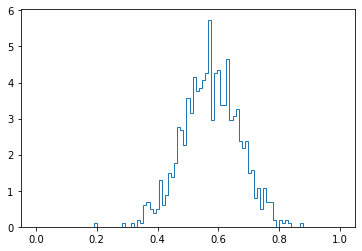

In [40]:
#추가
import matplotlib.pyplot as plt

plt.hist(bs_alpha, bins=np.linspace(0, 1, 100),  histtype=u'step', density=True) 
plt.show()


--------------------------------------

다시 horsepower 예시로 돌아가 봅시다

In [17]:
#주어진 관측치를 통해 X = horsepower, Y = mpg인 선형 회귀의 B0와 B1을 추출하는 함수를 만듭니다.

def boot_fn(data, start_index, end_index):
    m = LinearRegression(fit_intercept=True).fit(
        data['horsepower'][start_index:end_index].values.reshape(-1, 1),
        data['mpg'][start_index:end_index]
    )
    
    return m.intercept_, m.coef_
    
boot_fn(auto, 0, 392) #auto data set의 관측치는 392개입니다.

(39.935861021170467, array([-0.15784473]))

In [18]:
#Resample을 거친 auto에도 동일한 함수를 적용합니다. 큰 차이가 나지 않습니다.

boot_fn(resample(auto, replace=True, n_samples=392), 0, 392)

(39.976257979933948, array([-0.15837384]))

In [19]:
#1000번의 Resampling을 통해 B0, B1의 분포에 대한 정보(평균과 표준편차)를 구합니다.

bs_boot = {'t1': [], 't2': []}

for i in range(0, 1000):
    bs_boot['t1'].append(
        boot_fn(resample(auto, replace=True, n_samples=392), 0, 392)[0]
    )
    bs_boot['t2'].append(
        boot_fn(resample(auto, replace=True, n_samples=392), 0, 392)[1][0]
    )

t1_es = np.array(bs_boot['t1']).mean()
t1_se = np.array(bs_boot['t1']).std()
t2_es = np.array(bs_boot['t2']).mean()
t2_se = np.array(bs_boot['t2']).std()

print('t1 bs estimate & se:', t1_es, t1_se)
print('t2 bs estimate & se:', t2_es, t2_se)

t1 bs estimate & se: 39.9525008766 0.87663899372
t2 bs estimate & se: -0.158546240855 0.00740859983384


In [20]:
#stats model을 통해 비교해 봅시다.

import statsmodels.formula.api as sm

ols = sm.ols('mpg ~ horsepower', data=auto).fit()
ols.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,39.9359,0.717,55.660,0.000,38.525,41.347
horsepower,-0.1578,0.006,-24.489,0.000,-0.171,-0.145


In [21]:
#Polynomial Regression에도 적용해 봅시다.

def boot_fn2(data, start_index, end_index):
    m = LinearRegression(fit_intercept=True).fit(
        data[['horsepower', 'horsepower_2']][start_index:end_index],
        data['mpg'][start_index:end_index]
    )
    
    return m.intercept_, m.coef_

In [22]:
bs_boot2 = {'t1': [], 't2': [], 't3': []}

for i in range(0, 1000):
    bs_boot2['t1'].append(
        boot_fn2(resample(auto, replace=True, n_samples=392), 0, 392)[0]
    )
    bs_boot2['t2'].append(
        boot_fn2(resample(auto, replace=True, n_samples=392), 0, 392)[1][0]
    )
    bs_boot2['t3'].append(
        boot_fn2(resample(auto, replace=True, n_samples=392), 0, 392)[1][1]
    )


t1_es = np.array(bs_boot2['t1']).mean()
t1_se = np.array(bs_boot2['t1']).std()
t2_es = np.array(bs_boot2['t2']).mean()
t2_se = np.array(bs_boot2['t2']).std()
t3_es = np.array(bs_boot2['t3']).mean()
t3_se = np.array(bs_boot2['t3']).std()

print('t1 bs estimate & se:', t1_es, t1_se)
print('t2 bs estimate & se:', t2_es, t2_se)
print('t3 bs estimate & se:', t3_es, t3_se)

t1 bs estimate & se: 56.9019483024 2.09407566128
t2 bs estimate & se: -0.467255812708 0.0328945365585
t3 bs estimate & se: 0.00123678486306 0.000123419462541


In [23]:
import statsmodels.formula.api as sm

ols2 = sm.ols('mpg ~ horsepower + horsepower_2', data=auto).fit()
ols2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
horsepower_2,0.0012,0.000,10.080,0.000,0.001,0.001
